# Predicting Listing Gains in the Indian IPO Market Using TensorFlow

## Introduction

In this project, we'll work as a data scientist for an investment firm that is interested in investing in the Initial Public Offerings (IPO) in the Indian market. Our task is to build a deep learning classification model to determine if there will be listing gains for the IPO. Listing gains are the percentage increase in the share price of a company from its IPO issue price on the day of listing.

The dataset we'll be using for this project contains information on past IPOs in the Indian market and comes from [moneycontrol.](https://www.moneycontrol.com/ipo/ipo-historic-table?classic=true)

We'll cover all the major steps of the modeling pipeline, starting with exploratory data analysis, then moving on to visualizing the important variables, then finally creating a deep learning classification model.

### Data Dictionary

The data consists of following columns:
- Date: date when the IPO was listed
- IPOName: name of the IPO
- Issue_Size: size of the IPO issue, in INR Crores
- Subscription_QIB: number of times the IPO was subscribed by the QIB (Qualified Institutional Buyer) investor category
- Subscription_HNI: number of times the IPO was subscribed by the HNI (High Networth Individual) investor category
- Subscription_RII: number of times the IPO was subscribed by the RII (Retail Individual Investors) investor category
- Subscription_Total: total number of times the IPO was subscribed overall
- Issue_Price: the price in INR at which the IPO was issued
- Listing_Gains_Percent: is the percentage gain in the listing price over the issue price

In [117]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [118]:
df = pd.read_csv("C:/DATABASES/Indian_IPO_Market_Data.csv")

In [119]:
df.head()

,Date,IPOName,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Percent
0,03/02/10,Infinite Comp,189.80,48.44,106.02,11.08,43.22,165,11.82
1,08/02/10,Jubilant Food,328.70,59.39,51.95,3.79,31.11,145,-84.21
2,15/02/10,Syncom Health,56.25,0.99,16.60,6.25,5.17,75,17.13
3,15/02/10,Vascon Engineer,199.80,1.12,3.65,0.62,1.22,165,-11.28
4,19/02/10,Thangamayil,0.00,0.52,1.52,2.26,1.12,75,-5.20


## Exploring the Data

As we stated earlier, we'll be building a deep learning classification model. However, the Listing_Gains_Percent target variable is continuous. Therefore, we will need to convert it into a categorical variable before we can proceed.

We'll then do some data exploration to determine what data preprocessing we'll need to perform on our dataset.

In [120]:
df["Listing_Gains_Profit"] = 0
df.loc[df["Listing_Gains_Percent"] > 0, "Listing_Gains_Profit"] = 1

In [121]:
df.sample(5,random_state=9)

,Date,IPOName,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Percent,Listing_Gains_Profit
318,17/10/22,Electronics Mar,500.00,58.81,15.39,8.27,24.23,59,43.14,1
180,27/09/17,ICICI Lombard,5700.94,8.93,0.83,1.23,2.98,661,3.11,1
57,20/12/10,Claris Life,300.00,1.31,2.03,1.60,1.50,228,-9.71,0
31,18/08/10,Bajaj Consumer,297.00,20.19,53.49,6.62,19.29,660,-77.02,0
100,30/05/12,Speciality Rest,181.96,4.68,2.19,0.55,2.54,150,7.10,1


We created a new column, Listing_Gains_Profit that has the value 1 when Listing_Gains_Percent is positive and 0 when it's negative. Now, let's check if there are any null values.

In [122]:
df.shape

(319, 10)

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   319 non-null    object 
 1   IPOName                319 non-null    object 
 2   Issue_Size             319 non-null    float64
 3   Subscription_QIB       319 non-null    float64
 4   Subscription_HNI       319 non-null    float64
 5   Subscription_RII       319 non-null    float64
 6   Subscription_Total     319 non-null    float64
 7   Issue_Price            319 non-null    int64  
 8   Listing_Gains_Percent  319 non-null    float64
 9   Listing_Gains_Profit   319 non-null    int64  
dtypes: float64(6), int64(2), object(2)
memory usage: 25.1+ KB


We see that there are no null values.

Now, we'll check out the distribution of our target variable.

In [124]:
df["Listing_Gains_Profit"].value_counts(normalize=True)

Listing_Gains_Profit
1    0.545455
0    0.454545
Name: proportion, dtype: float64

We see that the frequencies of our target variable are close, with more ones (54%) than zeroes (45%).

## Data Visualization

Let's further analyze and understand our data using visualizations. We will check for outliers using the boxplot method. We'll first drop the Date and IPOName columns as they are unnecessray for our purposes.

In [125]:
df = df.drop(columns=["Date ", "IPOName"], axis=1)
df.columns

Index(['Issue_Size', 'Subscription_QIB', 'Subscription_HNI',
       'Subscription_RII', 'Subscription_Total', 'Issue_Price',
       'Listing_Gains_Percent', 'Listing_Gains_Profit'],
      dtype='object')

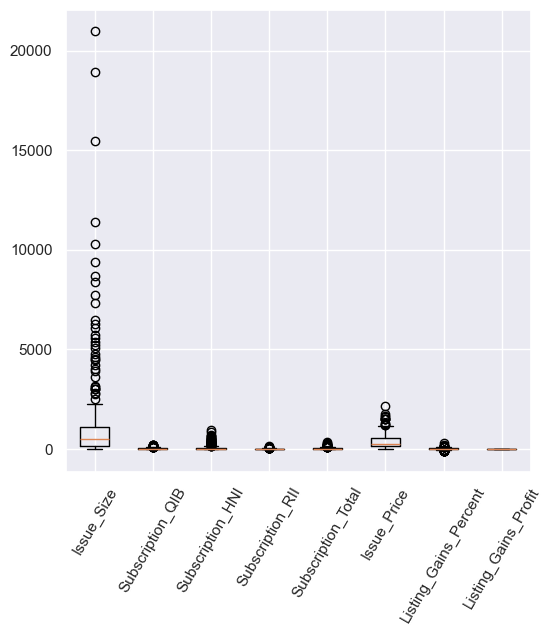

In [126]:
plt.figure(figsize=(6,6))
plt.boxplot(df,labels=df.columns)
plt.xticks(rotation=60)
plt.show()

In [127]:
for col in df:

    quartiles = np.percentile(df[col], [25, 50, 75])
    iqr = quartiles[2] - quartiles[0]
    lower_bound = quartiles[0] - (1.5 * iqr)
    upper_bound = quartiles[2] + (1.5 * iqr)
    num_outliers =sum((df[col] < lower_bound) | (df[col] > upper_bound))

    print(f"The {col} column has {num_outliers} outliers according to the boxplot method.")

The Issue_Size column has 34 outliers according to the boxplot method.
The Subscription_QIB column has 35 outliers according to the boxplot method.
The Subscription_HNI column has 48 outliers according to the boxplot method.
The Subscription_RII column has 33 outliers according to the boxplot method.
The Subscription_Total column has 31 outliers according to the boxplot method.
The Issue_Price column has 12 outliers according to the boxplot method.
The Listing_Gains_Percent column has 46 outliers according to the boxplot method.
The Listing_Gains_Profit column has 0 outliers according to the boxplot method.


There seems to be outliers, which we'll deal with shortly. Let's now visualize the correlation of our variables with our target variable.

In [128]:
df.corr()

,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Percent,Listing_Gains_Profit
Issue_Size,1.000000,-0.037724,-0.103484,-0.147791,-0.093351,0.364733,0.019782,0.004717
Subscription_QIB,-0.037724,1.000000,0.773933,0.437462,0.815785,0.188105,0.395864,0.323499
Subscription_HNI,-0.103484,0.773933,1.000000,0.622993,0.954816,0.037283,0.375127,0.271879
Subscription_RII,-0.147791,0.437462,0.622993,1.000000,0.718738,-0.072112,0.424873,0.240842
Subscription_Total,-0.093351,0.815785,0.954816,0.718738,1.000000,0.051174,0.410753,0.283340
Issue_Price,0.364733,0.188105,0.037283,-0.072112,0.051174,1.000000,0.017544,0.039548
Listing_Gains_Percent,0.019782,0.395864,0.375127,0.424873,0.410753,0.017544,1.000000,0.673510
Listing_Gains_Profit,0.004717,0.323499,0.271879,0.240842,0.283340,0.039548,0.673510,1.000000


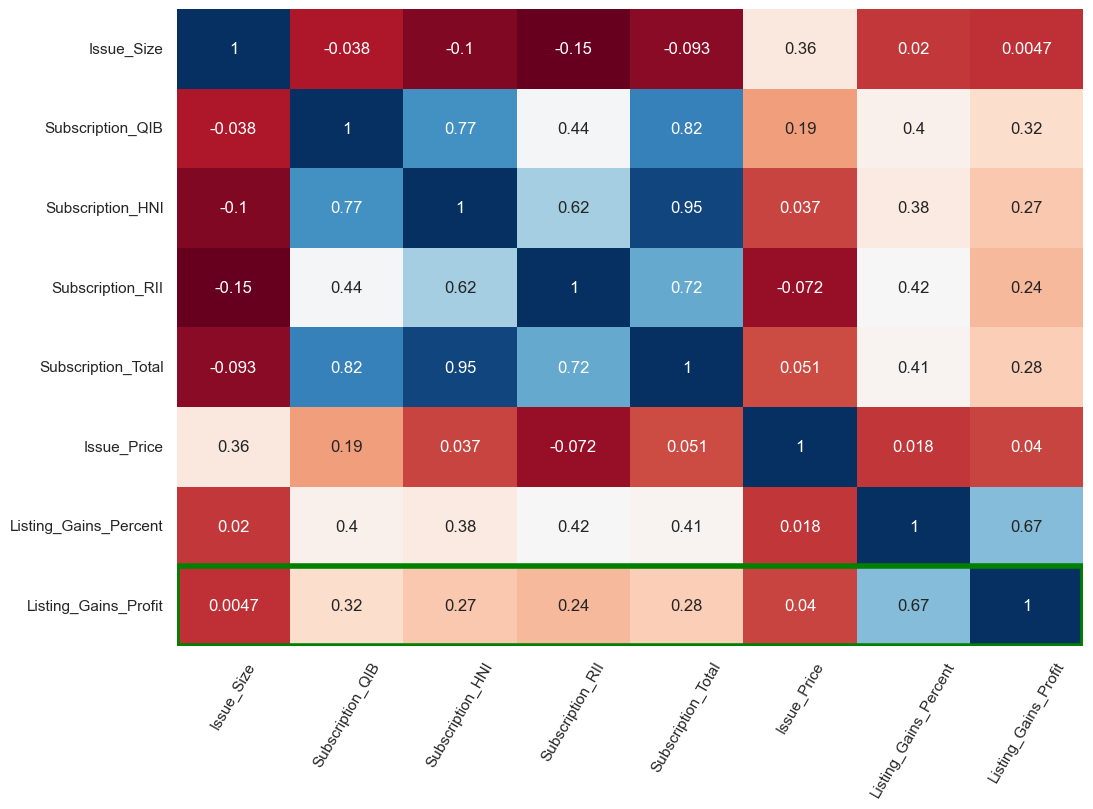

In [129]:
from matplotlib.patches import Rectangle
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
ax = sns.heatmap(df.corr(),cbar=False,
                     cmap='RdBu',annot=True)

ax.add_patch(Rectangle((0, 7), 8, 1, fill=False, edgecolor='green', lw=4))
plt.xticks(rotation=60)
plt.show()

We see that Subscription_QIB, Subscription_HNI, Subscription_RII and Subscription_Total are all good candidates for features.

## Outlier Treatment & Setting the Target and Predictor Variables

Here, we will deal with the outliers and normalize our data. We will first use IQR to find and remove the outliers. Let's write a simple function and run it.

In [130]:
def outlier_remover(df,col):
    q1 = df[col].quantile(q=0.25)
    q3 = df[col].quantile(q=0.75)  
    iqr = q3 - q1   
    lower = (q1 - 1.5 * iqr) 
    upper = (q3 + 1.5 * iqr) 
    df[col] = df[col].clip(lower, upper)

In [131]:
target_variable = ["Listing_Gains_Profit"]
target_variable2 = ["Listing_Gains_Percent"]
predictors = list(set(list(df.columns)) - set(target_variable)- set(target_variable2))

for col in predictors:
    outlier_remover(df,col)

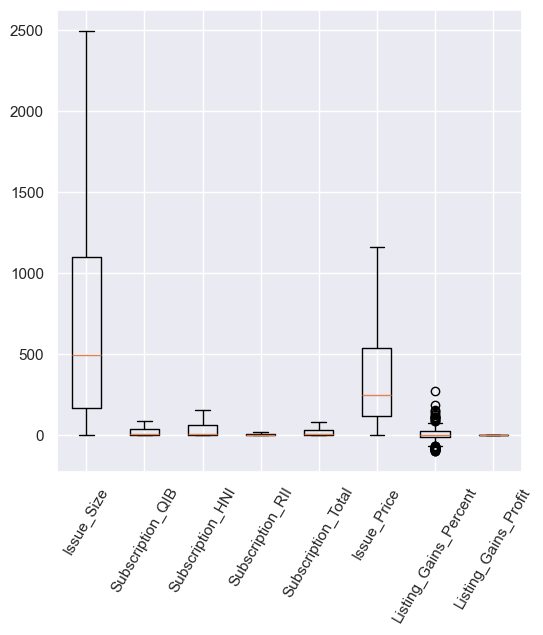

In [132]:
plt.figure(figsize=(6,6))
plt.boxplot(df,labels=df.columns)
plt.xticks(rotation=60)
plt.show()

Our data looks much better. We'll now use IQR Robust Scaler Transform to scale the data since it is more resistant to any outliers that may still be around.

In [154]:
features_copy = df[predictors].copy()

from sklearn.preprocessing import RobustScaler
trans = RobustScaler(unit_variance=True).fit(features_copy)
scaled_predictors = trans.transform(features_copy)

In [155]:
scaled_predictors

array([[ 1.75244462,  2.23832151,  1.62684803, -0.27497184, -0.44403543,
         1.40971118],
       [ 2.19357724,  1.03945034,  1.11232388, -0.3396711 , -0.24277415,
         0.0680931 ],
       [-0.15913003,  0.2556498 ,  0.01019701, -0.5661185 , -0.63754476,
         0.52082019],
       ...,
       [-0.17846735, -0.0731695 , -0.1504059 ,  0.88961478,  0.4285315 ,
         0.00368071],
       [ 3.2197645 ,  0.78247019,  1.79552358,  0.25879703,  0.37491979,
         1.65999933],
       [ 2.17021131,  0.22882098,  0.82000959, -0.6178779 ,  0.00543362,
         0.8925717 ]])

We'll now normalize the predictors to scale their values to between 0 and 1.

In [169]:
scaled_predictors = scaled_predictors/scaled_predictors.max()

In [170]:
scaled_predictors

array([[ 0.53300458,  0.68078363,  0.49480448, -0.08363246, -0.13505301,
         0.42876248],
       [ 0.66717469,  0.31614796,  0.33831238, -0.10331068, -0.07383955,
         0.02071046],
       [-0.04839927,  0.07775567,  0.00310141, -0.17218447, -0.19390871,
         0.15840703],
       ...,
       [-0.0542807 , -0.02225444, -0.04574583,  0.2705756 ,  0.1303375 ,
         0.00111948],
       [ 0.97928869,  0.23798766,  0.546107  ,  0.0787129 ,  0.11403154,
         0.50488742],
       [ 0.66006797,  0.06959571,  0.24940523, -0.18792705,  0.00165263,
         0.27147494]])

## Creating the Holdout Validation Approach

Now, it is time to divide the data into training and test sets. We'll do a 70/30 split.

In [171]:
X = scaled_predictors
y = df[target_variable].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=13)
print(X_train.shape); print(X_test.shape)

(223, 6)
(96, 6)


Now, data is ready for the model.

## Defining the Deep Learning Classification Model

It is finally time to define our model. We will
- instantiate the model,
- add the hidden layers,
- select the activation functions.

In [172]:
tf.random.set_seed(100)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(32, input_shape = (X_train.shape[1],), activation = 'relu'))
model.add(tf.keras.layers.Dense(16, activation= 'relu'))
model.add(tf.keras.layers.Dense(8, activation= 'relu'))
model.add(tf.keras.layers.Dense(4, activation= 'relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Compiling and Training the model

The model will now be introduced to our data. We'll compile and train the model. Since our target is binary, we'll use BinaryCrossentropy. As for our metric, we'll go with accuracy.

In [173]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [174]:
model.fit(X_train, y_train, epochs=250, verbose=0)

In [175]:
model.evaluate(X_train, y_train)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7997 - loss: 0.4460  


[0.4444487392902374, 0.7937219738960266]

In [176]:
model.evaluate(X_test, y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6328 - loss: 0.8327 


[0.7889304161071777, 0.65625]

## Model Evaluation

Our model has 79.3% accuracy with training data and 65.6% accuracy with the test data. The fact that there is such a difference between the two would suggest that our model may be suffering from overfitting. Some further steps that can be taken to improve the accuracy are as follows:

- Hyperparameter Optimization: tuning the hyperparameters like learning rate, number of layers, etc., is important for finding the optimal configuration of the deep learning model. We could try to tune the hyperparameters and examine the changes in the model accuracy.
- Optimizers and Loss Functions: we can use different optimizers and loss functions to see which one improves the model performance.
- Features: instead of using the base predictors in the data, we can try to construct new features that might help improve the model's predictive ability.
- Performance Metrics: instead of using accuracy as the performance metric, we may try other performance metrics to see if that helps guide the model toward better results.
- Domain Specific Knowledge: using domain specific knowledge to adjust our model can further enhance its performance and accuracy.